## Categorically Speaking

Creating a good model is more about _feature engineering_ than it is about choosing the right model. Feature engineering means improving, acquiring, and even _synthesizing_ features that are strong predictors of your model's target variable. Synthesizing features means deriving new features from existing features or injecting features from other data sources.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from rfpimp import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder

plt.rcParams["figure.figsize"] = (20, 7)
plt.style.use('dark_background')

### Baseline Model

In [2]:
# let's get a baseline using just the cleaned up numeric features from rent.csv in the data directory
df = pd.read_csv('../data/rent.csv')

# strip extreme prices, and remove apartments not in New York City
df_clean = df[(df.price > 1_000) & (df.price < 10_000)]
df_clean = df_clean[(df_clean.longitude != 0) | (df_clean.latitude != 0)]
df_clean = df_clean[(df_clean['latitude'] > 40.55) &
                    (df_clean['latitude'] < 40.94) &
                    (df_clean['longitude'] > -74.1) &
                    (df_clean['longitude'] < -73.67)]

df = df_clean

In [3]:
# numeric training data set and features
numfeatures = ['bathrooms', 'bedrooms', 'longitude', 'latitude']
X, y = df[numfeatures], df['price']

# train the base RF model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
rf.fit(X, y)

# get model OOB score
oob_baseline = rf.oob_score_
print(f'OOB score: ', oob_baseline)

OOB score:  0.8680143014216576


In [4]:
# function that calculates and plots feature importances
def showimp(random_forest, X, y):
    features = list(X.columns)
    features.remove('latitude')
    features.remove('longitude')
    features += [['latitude','longitude']]

    importances_ = importances(random_forest, X, y, features=features)
    plot_importances(importances_, color='#4575b4', width=15,minheight=5)

# test the model given features and target variable
def test(X, y):
    rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, oob_score=True)
    rf.fit(X, y)

    oob = rf.oob_score_
    n = rfnnodes(rf)
    h = np.median(rfmaxdepths(rf))

    print(f"OOB R^2 {oob:.5f} using {n:,d} tree nodes with {h} median tree height")
    return rf, oob

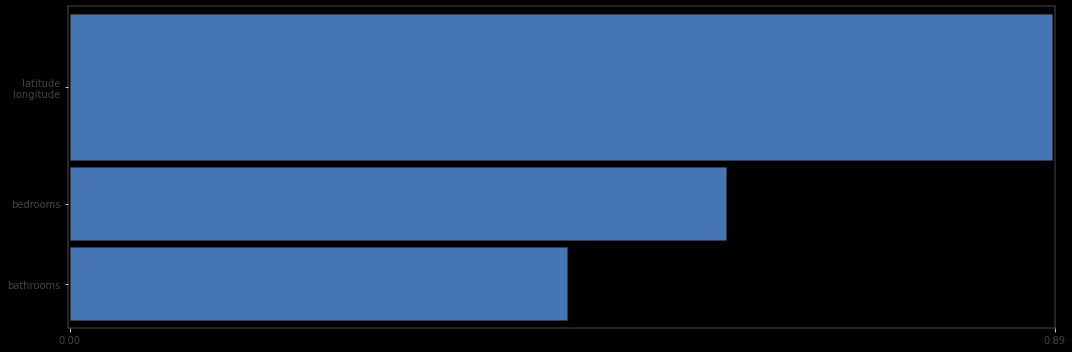

In [5]:
showimp(rf, X, y)

Now that we have a good benchmark for model and feature performance, let's try to improve our model by converting some existing nonnumeric features into numeric features.

### Encoding Categorical Variables

The **interest_level** feature is a categorical variable that seems to encode interest in an apartment. It's a categorical variable because it takes on values from a finite set of choices: _low_, _medium_, and _high_. More specifically, **interest_level** is an _ordinal categorical variable_, which means that the values can be ordered even if they are not actual numbers.

In [6]:
# count number of points / apartments for each "interest_level"
print(df['interest_level'].value_counts(), '\n')

# ordinal variables are the easiest to convert from strings to numbers 
# because we can simply assign a different integer for each possible ordinal value
df['interest_level'] = df['interest_level'].map({'low':1,'medium':2,'high':3})
print(df['interest_level'].value_counts())


low       33270
medium    11203
high       3827
Name: interest_level, dtype: int64 

1    33270
2    11203
3     3827
Name: interest_level, dtype: int64


In [7]:
# 0.870 score is only a little bit better than our baseline of 0.868, but it's still useful.
X, y = df[['interest_level']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.87030 using 3,024,914 tree nodes with 35.0 median tree height


Ordinal categorical variables are simple to encode numerically. Unfortunately, there's another kind of categorical variable called a nominal variable for which there is no meaningful order between the category values. For example, in this data set, columns **manager_id**, **building_id**, and **display_address** are nominal features. Without an order between categories, it's hard to encode nominal variables as numbers in a meaningful way, particularly when there are very many category values. The easy way to remember the difference between ordinal and nominal variables is that ordinal variables have order and nominal comes from the word for "name" in Latin (nomen) or French (nom).


In [8]:
print(len(df['manager_id'].unique()), len(df['building_id'].unique()), len(df['display_address'].unique()))

3409 7417 8692


The first technique is called _label encoding_ and simply converts each category to a numeric value, as we did before, while ignoring the fact that the categories are not really ordered. Sometimes an RF can get some predictive power from features encoded in this way but typically requires larger trees in the forest.

In [9]:
# label encoding
df['display_address_cat'] = df['display_address'].astype('category').cat.as_ordered()
df['display_address_cat'] = df['display_address_cat'].cat.codes + 1

# unfortunately, the  score is roughly the same as the baseline's score and 
# it increases the tree height. Not a good trade
X, y = df[['display_address_cat']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86566 using 3,119,062 tree nodes with 37.0 median tree height


Let's try another encoding approach called _frequency encoding_ and apply it to the **manager_id** feature. Frequency encoding converts categories to the frequencies with which they appear in the training.

In [10]:
print(df['manager_id'].value_counts().head(5))

e6472c7237327dd3903b3d6f6a94515a    2509
6e5c10246156ae5bdcd9b487ca99d96a     695
8f5a9c893f6d602f4953fcc0b8e6e9b4     404
62b685cc0d876c3a1a51d63a0d6a8082     396
cb87dadbca78fad02b388dc9e8f25a5b     370
Name: manager_id, dtype: int64


In [11]:
# frequency encoding
managers_count = df['manager_id'].value_counts()
df['mgr_apt_count'] = df['manager_id'].map(managers_count)

X, y = df[['display_address_cat','mgr_apt_count']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86458 using 4,570,596 tree nodes with 40.0 median tree height


We can conclude that, for this data set, label encoding and frequency encoding of high-cardinality categorical variables is not helpful. These encoding techniques could, however, be useful on other data set so it's worth learning them.

### Extracting Features from Strings

The apartment data set also has some variables that are both nonnumeric and noncategorical, **description** and **features**. Such arbitrary strings have no obvious numerical encoding, but we can extract bits of information from them to create new features. For example, an apartment with parking, doorman, dishwasher, and so on might fetch a higher price so let's _synthesize_ some Boolean features derived from string features.

In [12]:
# normalize description to lower case
df['description'] = df['description'].fillna('') # fill missing w/blanks
df['description'] = df['description'].str.lower()

# normalize features to lower case
df['features'] = df['features'].fillna('') # fill missing w/blanks
df['features'] = df['features'].str.lower()

# has apartment been renovated?
df['renov'] = df['description'].str.contains("renov")

for w in ['doorman', 'parking', 'garage', 'laundry', 'Elevator', 'fitness center', 'dishwasher']:
    df[w] = df['features'].str.contains(w)

display(df[['doorman', 'parking', 'garage', 'laundry']].head(5))

# another trick is to count the number of words in a string
df["num_desc_words"] = df["description"].apply(lambda x: len(x.split()))
df["num_features"] = df["features"].apply(lambda x: len(x.split(",")))

# there's not much we can do with the list of photo URLs, but the number of photos might be slightly predictive of price
df["num_photos"] = df["photos"].apply(lambda x: len(x.split(",")))

,doorman,parking,garage,laundry
0,False,False,False,True
1,True,False,False,True
2,True,False,False,True
3,False,False,False,False
4,True,False,False,True


In [13]:
textfeatures = [
    'num_photos', 'num_desc_words', 'num_features',
    'doorman', 'parking', 'garage', 'laundry', 
    'Elevator', 'fitness center', 'dishwasher',
    'renov'
]

X, y = df[textfeatures+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.86249 using 4,774,358 tree nodes with 43.0 median tree height


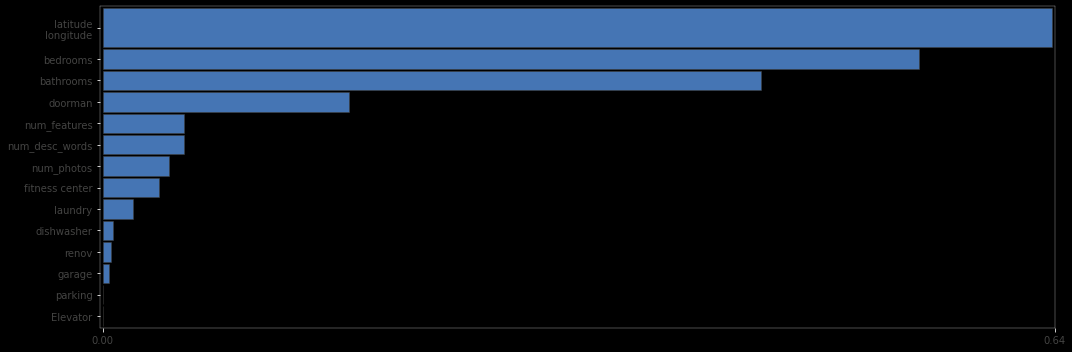

In [14]:
showimp(rf, X, y)

It's disappointing that the accuracy does not improve with these features and that the complexity of the model is higher, but this does provide useful marketing information. Apartment features such as parking, laundry, and dishwashers are attractive but there's little evidence that people are willing to pay more for them (except maybe for having a doorman).

### Synthesizing Numeric Features

In [15]:
# let's combine two numeric columns
# ratio of bedrooms to price
df["beds_per_price"] = df["bedrooms"] / df["price"]

X, y = df[['beds_per_price']+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.98627 using 1,313,946 tree nodes with 31.0 median tree height


That's almost a perfect score, which should trigger an alarm that it's too good to be true. In fact, we do have an error, but it's not a code bug. We have effectively copied the price column into the feature set, kind of like studying for a quiz by looking at the answers. This is a form of _data leakage_, which is a general term for the use of features that directly or indirectly hint at the target variable. As a general principle, you can't compute features for the validation set using information from the validation set. Only information computed directly from the training set can be used during feature engineering.

Creating features that incorporate information about the target variable is called **target encoding** and is often used to derive features from categorical variables to great effect. One of the most common target encodings is called _mean encoding_, which replaces each category value with the average target value associated with that category. For example, building managers in our apartment data set might rent apartments in certain price ranges. The manager IDs by themselves carry little predictive power but converting IDs to the average rent price for apartments they manage could be predictive.

In [16]:
df.groupby('building_id').mean()[['price']].head(5)

,price
building_id,
0,3195.9321
00005cb939f9986300d987652c933e15,3399.0000
00024d77a43f0606f926e2312513845c,2000.0000
000ae4b7db298401cdae2b0ba1ea8146,2400.0000
0012f1955391bca600ec301035b97b65,3700.0000


Unfortunately, it's easy to overfit models when incorporating target information. Preventing overfitting is nontrivial and it's best to rely on a library, such as the _category_encoders_ package contributed to sklearn (To prevent overfitting, the idea is to compute the mean from a subset of the training data targets for each category.).

In [17]:
df = df.reset_index()
targetfeatures = ['building_id']

encoder = TargetEncoder(cols=targetfeatures)
encoder.fit(df, df['price'])

df_encoded = encoder.transform(df, df['price'])

# look at X['building_id'] for details
X, y = df_encoded[targetfeatures+numfeatures], df['price']
rf, oob = test(X, y)

OOB R^2 0.87271 using 2,746,812 tree nodes with 39.0 median tree height


In [18]:
df_train, df_test = train_test_split(df, test_size=0.20)

# TargetEncoder needs the resets, not sure why
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# let's see what happens when we properly target encode the validation set, that is, using only data from the training set
enc = TargetEncoder(cols=targetfeatures)
enc.fit(df_train, df_train['price'])
df_train_encoded = enc.transform(df_train, df_train['price'])
df_test_encoded = enc.transform(df_test)

X_train = df_train_encoded[targetfeatures+numfeatures]
y_train = df_train_encoded['price']
X_test = df_test_encoded[targetfeatures+numfeatures]
y_test = df_test_encoded['price']

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(X_train, y_train)
s_tenc_validation = rf.score(X_test, y_test)
print(f"{s_tenc_validation:.4f} score {rfnnodes(rf):,d} tree nodes and {np.median(rfmaxdepths(rf))} median tree height")

0.8607 score 2,382,738 tree nodes and 38.0 median tree height


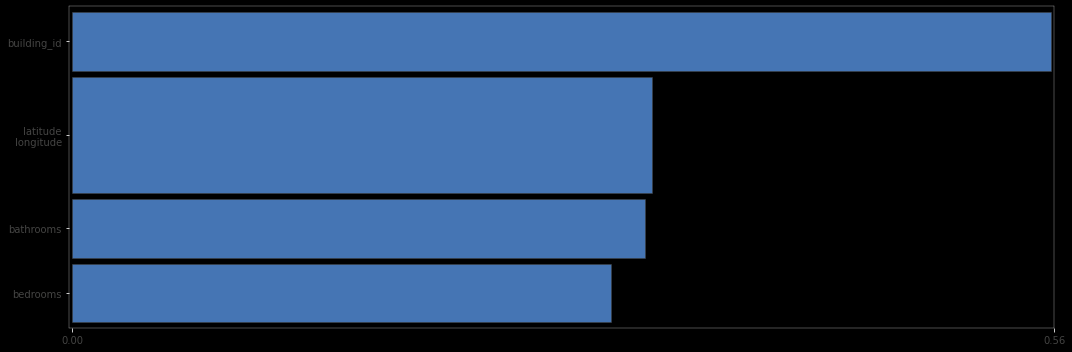

In [19]:
showimp(rf, X, y)

The model finds the target-encoded feature strongly predictive of the training set prices, causing it to overfit by overemphasizing this feature. This loss of generality explains the drop in validation scores. The feature importance graph provides evidence of this overemphasis because it shows the target-encoded building_id feature as the most important.